# Import Libraries

In [ ]:
!pip install numba==0.48
!pip install aif360==0.2.2

In [ ]:
!pip install kaggle -q #install the kaggle library

In [ ]:
!kaggle competitions download -c home-credit-default-risk
!mkdir project_files
!unzip home-credit-default-risk.zip -d project_files

In [ ]:
!pip install shap==0.39.0

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
np.random.seed(0)
from matplotlib import pyplot as plt
import seaborn as sn

In [ ]:
files.upload() #need kaggle API token from Kaggle->Your Account->Create new API Token
!rm -rf /root/.kaggle.
!mkdir /root/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#please refresh in Files tab before continuing

In [ ]:
files.upload() #for log_reg_baseline.csv

In [ ]:
files.upload() # for baseline_lgb.csv

In [ ]:
import json
from collections import OrderedDict
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

# Import Data

In [ ]:
app_test = pd.read_csv("project_files/application_test.csv")
app_train = pd.read_csv("project_files/application_train.csv")

result = pd.read_csv('log_reg_baseline.csv')
result.columns= ['SK_ID_CURR','Prediction']

lgb_result = pd.read_csv('baseline_lgb.csv')
lgb_result.columns =['SK_ID_CURR','Prediction']
#unused for analysis
#bureau = pd.read_csv("project_files/bureau.csv")
#bureau_bal = pd.read_csv("project_files/bureau_balance.csv")
#cc_bal = pd.read_csv("project_files/credit_card_balance.csv")
#installments_payments = pd.read_csv("project_files/installments_payments.csv")
#prev_app = pd.read_csv("project_files/previous_application.csv")

# Feature Description

For each input feature, describe its datatype, give information on missing values and on the value distribution. Show pairwise correlations between features if appropriate. Run any other reasonable profiling of the input that you find interesting and appropriate.

CODE_GENDER
*   Gender of the client

<br>AMT_INCOME_TOTAL
*   Income of the client

<br>NAME_HOUSING_TYPE
*   What is the housing situation of the client (renting, living with parents, ...)

<br>NAME_EDUCATION_TYPE
*   Level of highest education the client achieved

<br>DAYS_BIRTH
*   (Client's age in days at the time of application
time only relative to the application)



## Datatypes

In [ ]:
full_df = pd.concat([app_train,app_test],axis=0)
features_of_interest = full_df[['CODE_GENDER','DAYS_BIRTH','AMT_INCOME_TOTAL','NAME_HOUSING_TYPE','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE']]
features_of_interest.info() #2 float64, 3 objects(strings)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          356255 non-null  object 
 1   DAYS_BIRTH           356255 non-null  int64  
 2   AMT_INCOME_TOTAL     356255 non-null  float64
 3   NAME_HOUSING_TYPE    356255 non-null  object 
 4   NAME_EDUCATION_TYPE  356255 non-null  object 
 5   NAME_INCOME_TYPE     356255 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 19.0+ MB


## Value Distributions

### Age, Gender

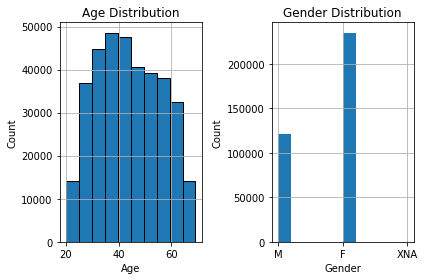

In [ ]:
#Age and Gender
plt.subplot(1,2,1)
features_of_interest['DAYS_BIRTH'].apply(lambda x: round(x*(-1/365),2)).hist(edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.subplot(1,2,2)

features_of_interest['CODE_GENDER'].hist(edgecolor='black')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Housing, Education Types

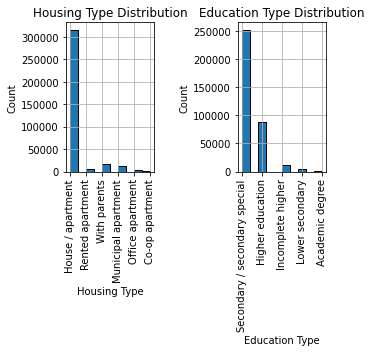

In [ ]:
#Housing & Education Types

plt.subplot(1,2,1)
features_of_interest['NAME_HOUSING_TYPE'].hist(edgecolor='black',xrot=90,figsize=(5,5))
plt.title('Housing Type Distribution')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.subplot(1,2,2)
features_of_interest['NAME_EDUCATION_TYPE'].hist(edgecolor='black',xrot=90,figsize=(5,5))
plt.title('Education Type Distribution')
plt.xlabel('Education Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Total Income

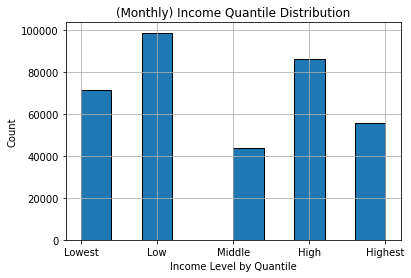

In [ ]:
#Total Income
plot_total_income = pd.qcut(features_of_interest['AMT_INCOME_TOTAL'], 5,
        labels = ['Lowest','Low','Middle','High','Highest'])

plot_total_income.sort_values().hist(edgecolor='black')

plt.title('(Monthly) Income Quantile Distribution')
plt.xlabel('Income Level by Quantile')
plt.ylabel('Count')
plt.show()

### Income Type

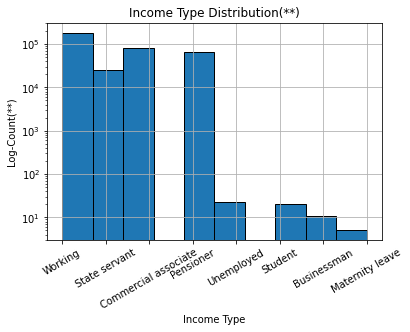

In [ ]:
fig,ax = plt.subplots()
ax.set_yscale('log')
plt.title('Income Type Distribution(**)'),
features_of_interest['NAME_INCOME_TYPE'].hist(edgecolor='black')
plt.xticks(rotation=30)
plt.xlabel('Income Type')
plt.ylabel('Log-Count(**)')
plt.show()

## Looking At Nulls

In [ ]:
#Nulls

features_of_interest.isnull().sum()

#not alot!
#These might be held by withheld or inapplicable or unknown

CODE_GENDER            0
DAYS_BIRTH             0
AMT_INCOME_TOTAL       0
NAME_HOUSING_TYPE      0
NAME_EDUCATION_TYPE    0
dtype: int64

## Correlation Heatmap

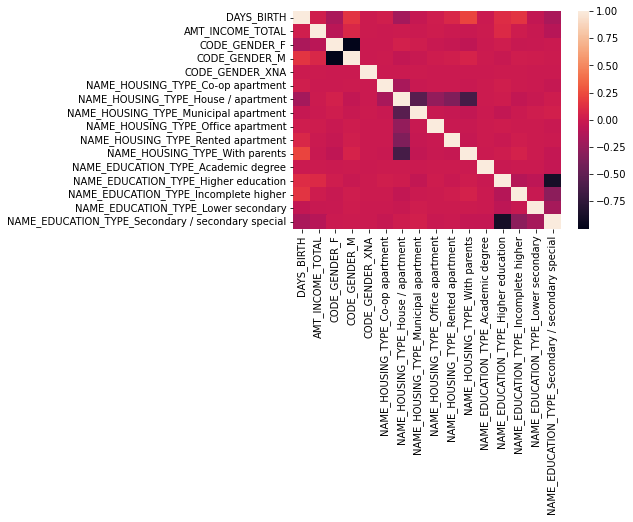

In [ ]:
corrMatrix = pd.get_dummies(features_of_interest).corr()
sn.heatmap(corrMatrix)
plt.show()

#Mostly low correlation, but have some spots, most interestingly between DAYS_BIRTH,AMT_INCOME_TOTAL and the rest.

# Training Dataset Analysis: Mean Difference & Disparate Impact
Using aif360 metrics to assess the bias of sensitive features in the dataset

In [ ]:
sensitive_features = ['CODE_GENDER','AMT_INCOME_TOTAL','NAME_HOUSING_TYPE','NAME_EDUCATION_TYPE','DAYS_BIRTH','NAME_INCOME_TYPE']

#Analyze Sensitive Features
analyze_sensitive = app_train[['SK_ID_CURR','TARGET'] + sensitive_features]

container = np.empty([6,2],dtype=float) * np.nan
#0: Gender| mean_diff | disp_impact
#1: Age   | mean_diff | disp_impact
#etc.

## Section 1: Gender

In [ ]:
analyze_gender =analyze_sensitive[['SK_ID_CURR','TARGET','CODE_GENDER']].copy()

analyze_gender=analyze_gender.drop(analyze_gender[analyze_gender['CODE_GENDER']=='XNA'].index,axis=0)
analyze_gender['CODE_GENDER'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
analyze_gender = analyze_gender.replace(analyze_gender['CODE_GENDER'].unique(),[1,0])

In [ ]:
#For analysis w/ mean_difference & disparate_impact using aif360 fairness metrics
dataset = StandardDataset(analyze_gender, 
                          label_name='TARGET', 
                          favorable_classes=[1], 
                          protected_attribute_names=['CODE_GENDER'], 
                          privileged_classes=[[1]])

metric_train = BinaryLabelDatasetMetric(
     dataset, 
     unprivileged_groups=[{'CODE_GENDER':0}],
     privileged_groups=[{'CODE_GENDER':1}]
)

In [ ]:
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
print("Disparate Impact = %f" % metric_train.disparate_impact())

container[0,0] = metric_train.mean_difference()
container[0,1] = metric_train.disparate_impact()

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.031426
Disparate Impact = 0.690138


In [ ]:
json_expl = MetricJSONExplainer(metric_train)
print(format_json(json_expl.mean_difference()))
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.03142592031777364",
  "numPositivesUnprivileged": 14170.0,
  "numInstancesUnprivileged": 202448.0,
  "numPositivesPrivileged": 10655.0,
  "numInstancesPrivileged": 105059.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.6901383610825922",
  "numPositivePredictionsUnprivileged": 14170.0,
  "numUnprivileged": 202448.0,
  "numPositivePredictionsPrivileged": 10655.0,
  "numPrivileged": 105059.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the p

## Section 2: Age

In [ ]:
analyze_age =analyze_sensitive[['SK_ID_CURR','TARGET']].copy()
transformed_age=analyze_sensitive['DAYS_BIRTH'].apply(lambda x: round(x*(-1/365),2))
 #transforming days_birth since application to age
 #using id_curr as index to ensure everything matches back up for next steps

In [ ]:
#now need to cut up into groups to measure across age subgroups.. Young/Old by iqr
transformed_age_cut=pd.qcut(transformed_age,q=4,labels=['Young','MidYoung','MidOld','Old'])
transformed_age_cut.unique()

['Young', 'MidOld', 'Old', 'MidYoung']
Categories (4, object): ['Young' < 'MidYoung' < 'MidOld' < 'Old']

In [ ]:
analyze_age = pd.concat([analyze_age,transformed_age_cut.replace(transformed_age_cut.unique(),[0,2,3,1])],axis=1)

In [ ]:
dataset = StandardDataset(analyze_age, 
                          label_name='TARGET', 
                          favorable_classes=[1], 
                          protected_attribute_names=['DAYS_BIRTH'], 
                          privileged_classes=[[1]])

metric_train = BinaryLabelDatasetMetric(
     dataset, 
     unprivileged_groups=[{'DAYS_BIRTH':0},{'DAYS_BIRTH':1}],
     privileged_groups=[{'DAYS_BIRTH':2},{'DAYS_BIRTH':3}]
)

In [ ]:
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
print("Disparate Impact = %f" % metric_train.disparate_impact())

container[1,0] = metric_train.mean_difference()
container[1,1] = metric_train.disparate_impact()

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.035057
Disparate Impact = 1.554730


In [ ]:
json_expl = MetricJSONExplainer(metric_train)
print(format_json(json_expl.mean_difference()))
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): 0.035057199242137",
  "numPositivesUnprivileged": 15110.0,
  "numInstancesUnprivileged": 153785.0,
  "numPositivesPrivileged": 9715.0,
  "numInstancesPrivileged": 153726.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.5547301091813437",
  "numPositivePredictionsUnprivileged": 15110.0,
  "numUnprivileged": 153785.0,
  "numPositivePredictionsPrivileged": 9715.0,
  "numPrivileged": 153726.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privil

## Section 3: Income
Might want to use fairlearn w/ this and the types for better assessment, the range will be too great for binary labels

In [ ]:
analyze_income =analyze_sensitive[['SK_ID_CURR','TARGET']].copy()

In [ ]:
#cut by iqr, 'class bracket'-like
transf_income = pd.qcut(analyze_sensitive['AMT_INCOME_TOTAL'],q=5,labels=['Lower','LowMid','Middle','UpperMid','Upper'])
transf_income.unique()

['UpperMid', 'Upper', 'Lower', 'LowMid', 'Middle']
Categories (5, object): ['Lower' < 'LowMid' < 'Middle' < 'UpperMid' < 'Upper']

In [ ]:
analyze_income = pd.concat([analyze_income,transf_income.replace(transf_income.unique(),[3,4,0,1,2])],axis=1)

In [ ]:
dataset = StandardDataset(analyze_income, 
                          label_name='TARGET', 
                          favorable_classes=[1], 
                          protected_attribute_names=['AMT_INCOME_TOTAL'], 
                          privileged_classes=[[1]])

metric_train = BinaryLabelDatasetMetric(
     dataset, 
     unprivileged_groups=[{'AMT_INCOME_TOTAL':0},{'AMT_INCOME_TOTAL':1}],
     privileged_groups=[{'AMT_INCOME_TOTAL':2},{'AMT_INCOME_TOTAL':3},{'AMT_INCOME_TOTAL':4}]
)

In [ ]:
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
print("Disparate Impact = %f" % metric_train.disparate_impact())

container[2,0] = metric_train.mean_difference()
container[2,1] = metric_train.disparate_impact()

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.006860
Disparate Impact = 1.088631


In [ ]:
json_expl = MetricJSONExplainer(metric_train)
print(format_json(json_expl.mean_difference()))
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): 0.006859626298882274",
  "numPositivesUnprivileged": 12590.0,
  "numInstancesUnprivileged": 149427.0,
  "numPositivesPrivileged": 12235.0,
  "numInstancesPrivileged": 158084.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0886307448984476",
  "numPositivePredictionsUnprivileged": 12590.0,
  "numUnprivileged": 149427.0,
  "numPositivePredictionsPrivileged": 12235.0,
  "numPrivileged": 158084.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the p

## Section 4: Housing Type

In [ ]:
analyze_housing = analyze_sensitive[['SK_ID_CURR','TARGET']].copy()
analyze_sensitive['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [ ]:
analyze_housing['NAME_HOUSING_TYPE'] = analyze_sensitive['NAME_HOUSING_TYPE'].replace(analyze_sensitive['NAME_HOUSING_TYPE'].unique(),[0,1,2,3,4,5])

In [ ]:
dataset = StandardDataset(analyze_housing, 
                          label_name='TARGET', 
                          favorable_classes=[1], 
                          protected_attribute_names=['NAME_HOUSING_TYPE'], 
                          privileged_classes=[[1]])

metric_train = BinaryLabelDatasetMetric(
     dataset,
     unprivileged_groups=[{'NAME_HOUSING_TYPE':1},{'NAME_HOUSING_TYPE':2},{'NAME_HOUSING_TYPE':3}],
     privileged_groups = [{'NAME_HOUSING_TYPE':0},{'NAME_HOUSING_TYPE':4},{'NAME_HOUSING_TYPE':5}]
     )

In [ ]:
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
print("Disparate Impact = %f" % metric_train.disparate_impact())

container[3,0] = metric_train.mean_difference()
container[3,1] = metric_train.disparate_impact()

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.028677
Disparate Impact = 1.368371


In [ ]:
json_expl = MetricJSONExplainer(metric_train)
print(format_json(json_expl.mean_difference()))
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): 0.02867651823534359",
  "numPositivesUnprivileged": 3292.0,
  "numInstancesUnprivileged": 30904.0,
  "numPositivesPrivileged": 21533.0,
  "numInstancesPrivileged": 276607.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.3683706719697062",
  "numPositivePredictionsUnprivileged": 3292.0,
  "numUnprivileged": 30904.0,
  "numPositivePredictionsPrivileged": 21533.0,
  "numPrivileged": 276607.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privil

## Section 5: Education Type

In [ ]:
analyze_edu = analyze_sensitive[['SK_ID_CURR','TARGET']].copy()
analyze_sensitive['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [ ]:
analyze_edu['NAME_EDUCATION_TYPE'] = analyze_sensitive['NAME_EDUCATION_TYPE'].replace(analyze_sensitive['NAME_EDUCATION_TYPE'].unique(),[0,1,2,3,4])

In [ ]:
dataset = StandardDataset(analyze_housing, 
                          label_name='TARGET', 
                          favorable_classes=[1], 
                          protected_attribute_names=['NAME_HOUSING_TYPE'], 
                          privileged_classes=[[1]])

metric_train = BinaryLabelDatasetMetric(
     dataset,
     unprivileged_groups=[{'NAME_HOUSING_TYPE':0},{'NAME_HOUSING_TYPE':3}],
     privileged_groups = [{'NAME_HOUSING_TYPE':1},{'NAME_HOUSING_TYPE':2},{'NAME_HOUSING_TYPE':5}]
     )

In [ ]:
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
print("Disparate Impact = %f" % metric_train.disparate_impact())

container[4,0] = metric_train.mean_difference()
container[4,1] = metric_train.disparate_impact()

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.038144
Disparate Impact = 0.672286


In [ ]:
json_expl = MetricJSONExplainer(metric_train)
print(format_json(json_expl.mean_difference()))
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.03814396062258649",
  "numPositivesUnprivileged": 22227.0,
  "numInstancesUnprivileged": 284051.0,
  "numPositivesPrivileged": 2426.0,
  "numInstancesPrivileged": 20843.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.6722858321283718",
  "numPositivePredictionsUnprivileged": 22227.0,
  "numUnprivileged": 284051.0,
  "numPositivePredictionsPrivileged": 2426.0,
  "numPrivileged": 20843.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privi

## Section 6: Income Type

In [ ]:
analyze_inctype = analyze_sensitive[['SK_ID_CURR','TARGET','NAME_INCOME_TYPE']].copy()
analyze_inctype['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [ ]:
analyze_inctype['NAME_INCOME_TYPE'] = analyze_inctype['NAME_INCOME_TYPE'].replace(analyze_inctype['NAME_INCOME_TYPE'].unique(),[0,1,2,3,4,5,6,7])

In [ ]:
dataset = StandardDataset(analyze_inctype, 
                          label_name='TARGET', 
                          favorable_classes=[1], 
                          protected_attribute_names=['NAME_INCOME_TYPE'], 
                          privileged_classes=[[1]])

metric_train = BinaryLabelDatasetMetric(
     dataset,
     unprivileged_groups=[{'NAME_INCOME_TYPE':3},{'NAME_INCOME_TYPE':4},{'NAME_INCOME_TYPE':5},{'NAME_INCOME_TYPE':7}],
     privileged_groups = [{'NAME_INCOME_TYPE':0},{'NAME_INCOME_TYPE':1},{'NAME_INCOME_TYPE':2},{'NAME_INCOME_TYPE':6}]
     )

In [ ]:
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train.mean_difference())
print("Disparate Impact = %f" % metric_train.disparate_impact())

container[5,0] = metric_train.mean_difference()
container[5,1] = metric_train.disparate_impact()

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.032603
Disparate Impact = 0.623539


In [ ]:
json_expl = MetricJSONExplainer(metric_train)
print(format_json(json_expl.mean_difference()))
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.03260275084546979",
  "numPositivesUnprivileged": 2992.0,
  "numInstancesUnprivileged": 55407.0,
  "numPositivesPrivileged": 21833.0,
  "numInstancesPrivileged": 252104.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.6235385013902662",
  "numPositivePredictionsUnprivileged": 2992.0,
  "numUnprivileged": 55407.0,
  "numPositivePredictionsPrivileged": 21833.0,
  "numPrivileged": 252104.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privi

## Section 7: Visuals

Remember: Logreg model accuracy (given by Kaggle) was a ~0.671

### Mean Difference

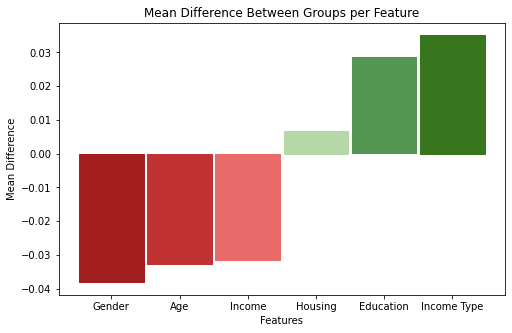

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
bars = plt.bar(range(0,6),sorted(container[:,0]),width=0.95,color = '#539553')
bars[0].set_color('#a31e1e')
bars[1].set_color('#c13333')
bars[2].set_color('#e86a6a')
bars[3].set_color('#b6d7a8')
bars[-1].set_color('#38761d')
plt.title('Mean Difference Between Groups per Feature')
ax.set_xticklabels([0,'Gender','Age','Income','Housing','Education','Income Type'])
plt.xlabel('Features')
plt.ylabel('Mean Difference')
plt.show()

### Disparate Impact

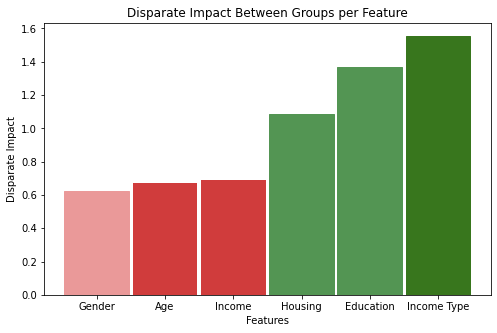

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
bars = plt.bar(range(0,6),sorted(container[:,1]),width=0.95,color = '#d03c3c')
bars[0].set_color('#ea9999')
bars[-3].set_color('#539553')
bars[-2].set_color('#539553')
bars[-1].set_color('#38761d')
plt.title('Disparate Impact Between Groups per Feature')
ax.set_xticklabels([0,'Gender','Age','Income','Housing','Education','Income Type'])
plt.xlabel('Features')
plt.ylabel('Disparate Impact')

plt.show()

# Test Dataset Analysis: Visuals w/ Logistic Regression

graphs looking at predictions across subgroups of sensitive features

## Section 1: Gender

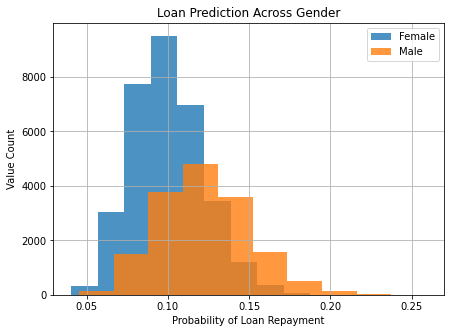

In [ ]:
gender_result = result.merge(app_test[['SK_ID_CURR','CODE_GENDER']],on=['SK_ID_CURR'])


fig,ax = plt.subplots()

fig.set_size_inches(7,5)
gender_result[gender_result['CODE_GENDER']=='F']['Prediction'].hist(label='Female',alpha=0.8)
gender_result[gender_result['CODE_GENDER']=='M']['Prediction'].hist(label='Male',alpha=0.8)
plt.title('Loan Prediction Across Gender')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('Value Count')
plt.legend()

plt.show()

## Section 2: Age

In [ ]:
age_result = result.merge(app_test[['SK_ID_CURR','DAYS_BIRTH']],on=['SK_ID_CURR']).copy()
age_result['DAYS_BIRTH']= age_result['DAYS_BIRTH'].apply(lambda x: round((-1)*x/365))

In [ ]:
age_brackets=pd.qcut(age_result['DAYS_BIRTH'],q=4).dtype

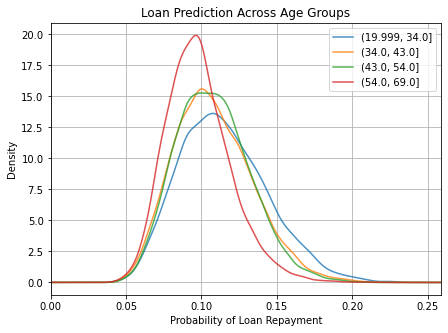

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)


for i in range(0,4,1):
  bracket = age_result['DAYS_BIRTH'].apply(lambda x: x in age_brackets.categories[i])
  age_result[bracket==True]['Prediction'].plot(kind='density',
                                                  label=age_brackets.categories[i],
                                                  alpha=0.8,
                                                  grid=True)

plt.xlim(left=0,right=age_result['Prediction'].max())
plt.title('Loan Prediction Across Age Groups')
plt.xlabel('Probability of Loan Repayment')

plt.legend()
plt.show()

## Section 3: Income

In [ ]:
income_result = result.merge(app_test[['SK_ID_CURR','AMT_INCOME_TOTAL']],on=['SK_ID_CURR']).copy()
income_brackets = pd.qcut(income_result['AMT_INCOME_TOTAL'],q=5).dtype

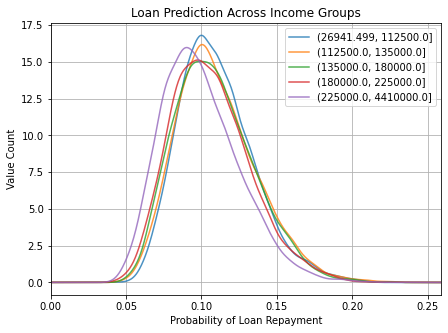

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)


for i in range(0,5,1):
  bracket = income_result['AMT_INCOME_TOTAL'].apply(lambda x: x in income_brackets.categories[i])
  income_result[bracket==True]['Prediction'].plot(kind='density',
                                                  label=income_brackets.categories[i],
                                                  alpha=0.8,
                                                  grid=True)

plt.xlim(left=0,right=income_result['Prediction'].max())
plt.title('Loan Prediction Across Income Groups')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('Value Count')

plt.legend()
plt.show()

## Section 4: Housing Type

In [ ]:
housing_result = result.merge(app_test[['SK_ID_CURR','NAME_HOUSING_TYPE']],on=['SK_ID_CURR']).copy()
housing_result['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'With parents', 'Rented apartment',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

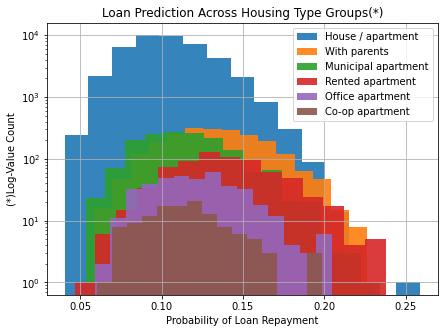

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)

ax.set_yscale('log')
for houseType in sorted(housing_result['NAME_HOUSING_TYPE'].unique(),
                        reverse=True,
                        key=lambda x: housing_result[housing_result['NAME_HOUSING_TYPE']==x].size): #easier-looking graph depth
  housing_result[housing_result['NAME_HOUSING_TYPE']==houseType]['Prediction'].hist(label=houseType,alpha=0.9,bins=15)

plt.title('Loan Prediction Across Housing Type Groups(*)')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('(*)Log-Value Count')

plt.legend()
plt.show()

## Section 5: Education Type

In [ ]:
edu_result = result.merge(app_test[['SK_ID_CURR','NAME_EDUCATION_TYPE']],on=['SK_ID_CURR']).copy()
edu_result['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

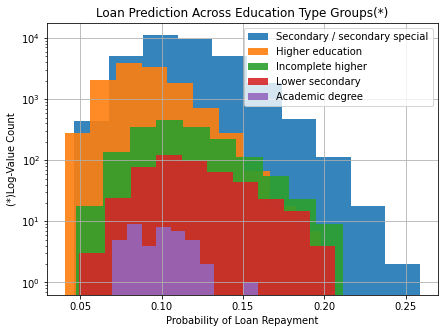

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)

ax.set_yscale('log')


for eduType in sorted(edu_result['NAME_EDUCATION_TYPE'].unique(),
                      reverse=True,
                      key=lambda x: edu_result[edu_result['NAME_EDUCATION_TYPE']==x].size): #easier-looking graph depth
  edu_result[edu_result['NAME_EDUCATION_TYPE']==eduType]['Prediction'].hist(label=eduType,alpha=0.9)

plt.title('Loan Prediction Across Education Type Groups(*)')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('(*)Log-Value Count')

plt.legend()
plt.show()

## Section 6: Income Type

In [ ]:
inctype_result = result.merge(app_test[['SK_ID_CURR','NAME_INCOME_TYPE']],on=['SK_ID_CURR']).copy()
inctype_result['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Pensioner', 'Commercial associate',
       'Businessman', 'Student', 'Unemployed'], dtype=object)

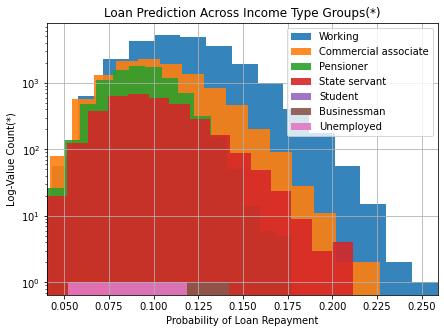

Student subgroup size:2.000000
Businessman subgroup size:1.000000 
Unemployed subgroup size:1.000000 


In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)
ax.set_yscale('log')

for incType in sorted(inctype_result['NAME_INCOME_TYPE'].unique(),
                      reverse=True,
                      key=lambda x: inctype_result[inctype_result['NAME_INCOME_TYPE']==x].size): #easier-looking graph depth
  inctype_result[inctype_result['NAME_INCOME_TYPE']==incType]['Prediction'].hist(label=incType,alpha=0.9,bins=15)

plt.xlim(left=inctype_result['Prediction'].min(),right=inctype_result['Prediction'].max())
plt.title('Loan Prediction Across Income Type Groups(*)')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('Log-Value Count(*)')
plt.legend()
plt.show()

print("Student subgroup size:%f" % inctype_result[inctype_result['NAME_INCOME_TYPE']=='Student'].shape[0])
print("Businessman subgroup size:%f " % inctype_result[inctype_result['NAME_INCOME_TYPE']=='Businessman'].shape[0])
print("Unemployed subgroup size:%f " % inctype_result[inctype_result['NAME_INCOME_TYPE']=='Unemployed'].shape[0])

# Performance w/ Logistic Regression

## Remaking the Model

In [ ]:
!pip install -U scikit-learn

In [ ]:
cat_cols=app_train.columns[app_train.dtypes == object]
missing_cols = ['CODE_GENDER_XNA','NAME_FAMILY_STATUS_Unknown','NAME_INCOME_TYPE_Maternity leave']

In [ ]:
remake_app_train = pd.get_dummies(app_train,columns=cat_cols).drop(missing_cols,axis=1)
remake_app_test = pd.get_dummies(app_test,columns=cat_cols)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in remake_app_train:
    train = remake_app_train.drop(columns = ['TARGET'])
else:
    train = remake_app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = remake_app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(remake_app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 242)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, app_train['TARGET'])

LogisticRegression(C=0.0001)

## Robustness & Stability

(LIME-like methods of assessment)

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict

In [ ]:
explainer = shap.LinearExplainer(log_reg, train, feature_perturbation="interventional")
# Apply it to the test data
shap_values = explainer.shap_values(test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


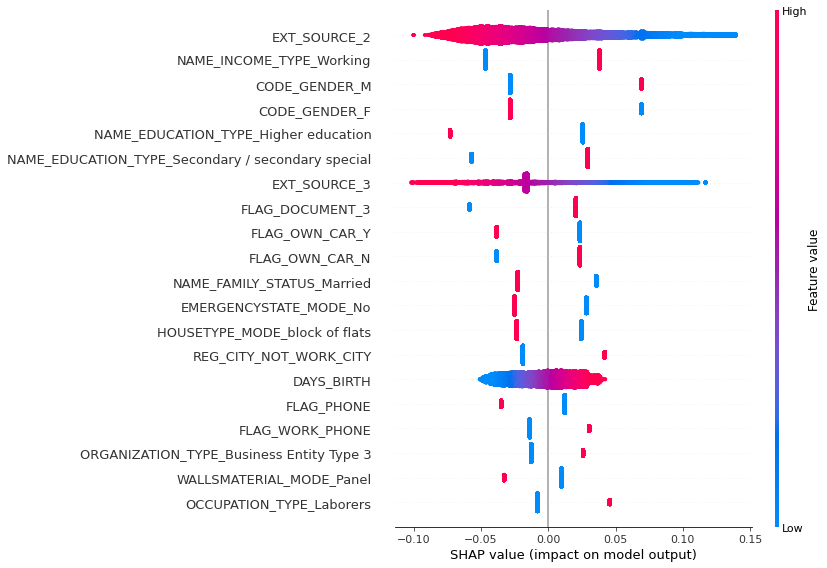

In [ ]:
 # We need to provide the data in dense format, not sparse
 shap.summary_plot(shap_values, test,feature_names = remake_app_test.columns)

 #The model seems to be picking up signals on things that wouldn't-or shouldn't-seem to matter,
 # like FLAG_PHONE & FLAG_WORK_PHONE.

### Individual SHAP Explanations

In [ ]:
shap.initjs()
idx = app_test[app_test['NAME_INCOME_TYPE']=='Unemployed'].index
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], test[idx,:],
    feature_names=remake_app_test.columns
)

In [ ]:
shap.initjs()
idx = app_test[app_test['NAME_INCOME_TYPE']=='Student'].index[0]
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], test[idx,:],
    feature_names=remake_app_test.columns
)

In [ ]:
shap.initjs()
idx = app_test[app_test['NAME_INCOME_TYPE']=='Student'].index[1]
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], test[idx,:],
    feature_names=remake_app_test.columns
)

In [ ]:
shap.initjs()
idx = app_test[app_test['NAME_INCOME_TYPE']=='Businessman'].index
shap.force_plot(
    explainer.expected_value, shap_values[idx,:], test[idx,:],
    feature_names=remake_app_test.columns
)

# Test Dataset Analysis: Visuals w/ Light Gradient Boosting Machine

## Section 1: Gender

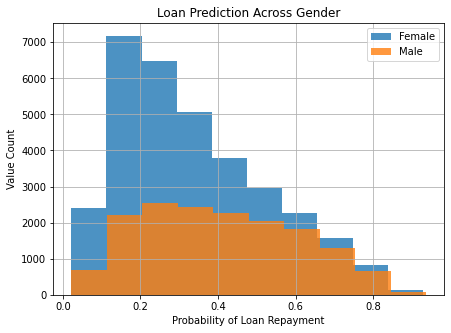

In [ ]:
gender_result = lgb_result.merge(app_test[['SK_ID_CURR','CODE_GENDER']],on=['SK_ID_CURR'])


fig,ax = plt.subplots()

fig.set_size_inches(7,5)
gender_result[gender_result['CODE_GENDER']=='F']['Prediction'].hist(label='Female',alpha=0.8)
gender_result[gender_result['CODE_GENDER']=='M']['Prediction'].hist(label='Male',alpha=0.8)
plt.title('Loan Prediction Across Gender')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('Value Count')
plt.legend()

plt.show()

## Section 2: Age

In [ ]:
age_result = lgb_result.merge(app_test[['SK_ID_CURR','DAYS_BIRTH']],on=['SK_ID_CURR']).copy()
age_result['DAYS_BIRTH']= age_result['DAYS_BIRTH'].apply(lambda x: round((-1)*x/365))

In [ ]:
age_brackets=pd.qcut(age_result['DAYS_BIRTH'],q=4).dtype

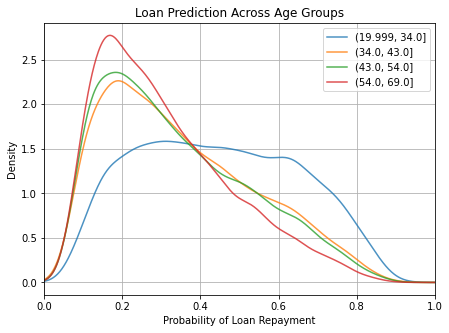

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)


for i in range(0,4,1):
  bracket = age_result['DAYS_BIRTH'].apply(lambda x: x in age_brackets.categories[i])
  age_result[bracket==True]['Prediction'].plot(kind='density',
                                                  label=age_brackets.categories[i],
                                                  alpha=0.8,
                                                  grid=True)

plt.xlim(left=0,right=1)
plt.title('Loan Prediction Across Age Groups')
plt.xlabel('Probability of Loan Repayment')

plt.legend()
plt.show()

## Section 3: (Monthly) Income

In [ ]:
income_result = lgb_result.merge(app_test[['SK_ID_CURR','AMT_INCOME_TOTAL']],on=['SK_ID_CURR']).copy()
income_brackets = pd.qcut(income_result['AMT_INCOME_TOTAL'],q=5).dtype

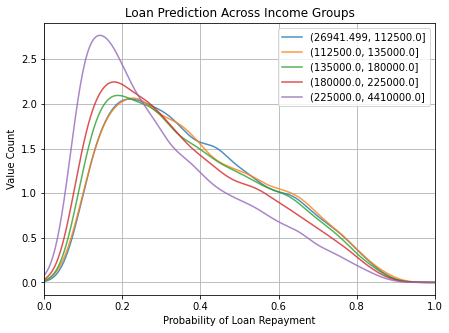

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)


for i in range(0,5,1):
  bracket = income_result['AMT_INCOME_TOTAL'].apply(lambda x: x in income_brackets.categories[i])
  income_result[bracket==True]['Prediction'].plot(kind='density',
                                                  label=income_brackets.categories[i],
                                                  alpha=0.8,
                                                  grid=True)

plt.xlim(left=0,right=1)
plt.title('Loan Prediction Across Income Groups')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('Value Count')

plt.legend()
plt.show()

## Section 4: Housing Type

In [ ]:
housing_result = lgb_result.merge(app_test[['SK_ID_CURR','NAME_HOUSING_TYPE']],on=['SK_ID_CURR']).copy()
housing_result['NAME_HOUSING_TYPE'].unique()

array(['House / apartment', 'With parents', 'Rented apartment',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

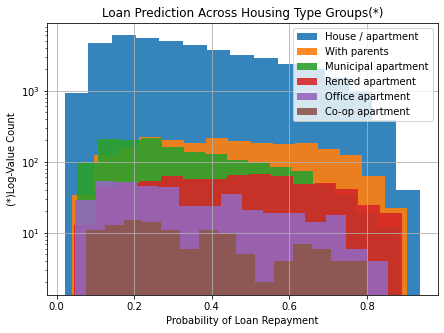

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)

ax.set_yscale('log')
for houseType in sorted(housing_result['NAME_HOUSING_TYPE'].unique(),
                        reverse=True,
                        key=lambda x: housing_result[housing_result['NAME_HOUSING_TYPE']==x].size): #easier-looking graph depth
  housing_result[housing_result['NAME_HOUSING_TYPE']==houseType]['Prediction'].hist(label=houseType,alpha=0.9,bins=15)

plt.title('Loan Prediction Across Housing Type Groups(*)')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('(*)Log-Value Count')

plt.legend()
plt.show()

## Section 5: Education Type

In [ ]:
edu_result = lgb_result.merge(app_test[['SK_ID_CURR','NAME_EDUCATION_TYPE']],on=['SK_ID_CURR']).copy()
edu_result['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

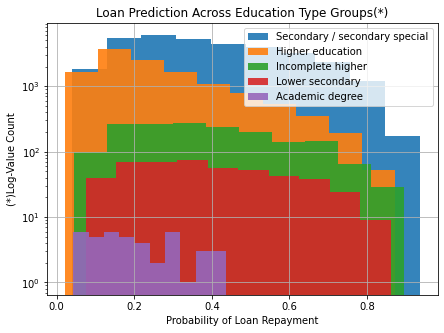

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(7,5)

ax.set_yscale('log')


for eduType in sorted(edu_result['NAME_EDUCATION_TYPE'].unique(),
                      reverse=True,
                      key=lambda x: edu_result[edu_result['NAME_EDUCATION_TYPE']==x].size): #easier-looking graph depth
  edu_result[edu_result['NAME_EDUCATION_TYPE']==eduType]['Prediction'].hist(label=eduType,alpha=0.9)

plt.title('Loan Prediction Across Education Type Groups(*)')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('(*)Log-Value Count')

plt.legend()
plt.show()

## Section 6: Income Type

In [ ]:
inctype_result = lgb_result.merge(app_test[['SK_ID_CURR','NAME_INCOME_TYPE']],on=['SK_ID_CURR']).copy()
inctype_result['NAME_INCOME_TYPE'].unique()

array(['Working', 'State servant', 'Pensioner', 'Commercial associate',
       'Businessman', 'Student', 'Unemployed'], dtype=object)

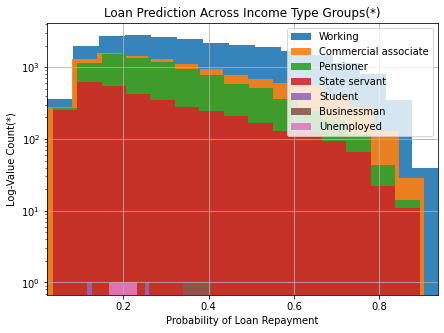

Student subgroup size:2.000000
Businessman subgroup size:1.000000 
Unemployed subgroup size:1.000000 


In [ ]:
fig,ax = plt.subplots()
ax.set_yscale('log')

for incType in sorted(inctype_result['NAME_INCOME_TYPE'].unique(),
                      reverse=True,
                      key=lambda x: inctype_result[inctype_result['NAME_INCOME_TYPE']==x].size): #easier-looking graph depth
  inctype_result[inctype_result['NAME_INCOME_TYPE']==incType]['Prediction'].hist(label=incType,alpha=0.9,bins=15,figsize=(7,5))

plt.xlim(left=inctype_result['Prediction'].min(),right=inctype_result['Prediction'].max())
plt.title('Loan Prediction Across Income Type Groups(*)')
plt.xlabel('Probability of Loan Repayment')
plt.ylabel('Log-Value Count(*)')
plt.legend()
plt.show()

print("Student subgroup size:%f" % inctype_result[inctype_result['NAME_INCOME_TYPE']=='Student'].shape[0])
print("Businessman subgroup size:%f " % inctype_result[inctype_result['NAME_INCOME_TYPE']=='Businessman'].shape[0])
print("Unemployed subgroup size:%f " % inctype_result[inctype_result['NAME_INCOME_TYPE']=='Unemployed'].shape[0])

# Performance w/ Light Gradient Boosting Machine

## Remaking the Model

This is not my code, it's from a Kaggle Competition submission: https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def modelfunc(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
_,fi,metrics= modelfunc(app_train, app_test)
print(metrics)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.798882	train's binary_logloss: 0.547678	valid's auc: 0.755525	valid's binary_logloss: 0.563196
Early stopping, best iteration is:
[234]	train's auc: 0.804502	train's binary_logloss: 0.542206	valid's auc: 0.755743	valid's binary_logloss: 0.559787
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.798461	train's binary_logloss: 0.548215	valid's auc: 0.758478	valid's binary_logloss: 0.563404
Early stopping, best iteration is:
[276]	train's auc: 0.810258	train's binary_logloss: 0.536484	valid's auc: 0.7587	valid's binary_logloss: 0.556356
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.797491	train's binary_logloss: 0.549643	valid's auc: 0.762759	valid's binary_logloss: 0.564665
Early stopping, best iteration is:
[268]	train's auc: 0.808601	train's binary_logloss: 0.5388

## Feature Importance

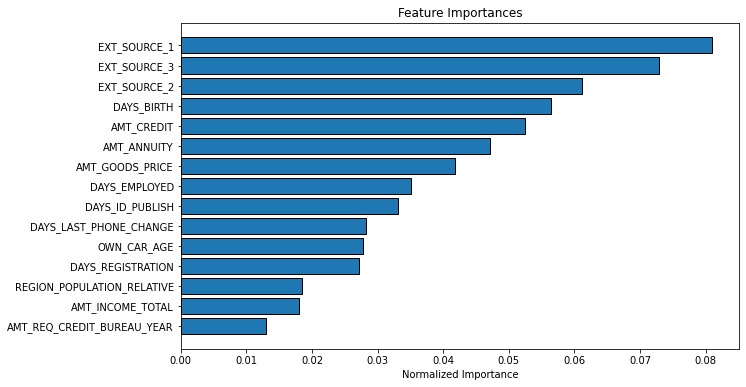

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
fi_sorted = plot_feature_importances(fi)